In [3]:
%cd /content/drive/MyDrive/faster_r-cnn/data
!unzip /content/drive/MyDrive/faster_r-cnn/data/black.zip
!unzip /content/drive/MyDrive/faster_r-cnn/data/green.zip

/content/drive/MyDrive/faster_r-cnn/data
Archive:  /content/drive/MyDrive/faster_r-cnn/data/black.zip
   creating: black/test/
  inflating: black/test/_coco_annotations.json  
  inflating: black/test/20220616_131603329_iOS.jpg  
  inflating: black/test/20220616_131606681_iOS.jpg  
  inflating: black/test/20220616_131645556_iOS.jpg  
  inflating: black/test/20220616_131654028_iOS.jpg  
  inflating: black/test/20220616_131656079_iOS.jpg  
  inflating: black/test/20220616_131709047_iOS.jpg  
  inflating: black/test/20220616_131742632_iOS.jpg  
  inflating: black/test/20220616_131754007_iOS.jpg  
  inflating: black/test/20220616_131800940_iOS.jpg  
  inflating: black/test/20220616_131808521_iOS.jpg  
  inflating: black/test/20220616_131818873_iOS.jpg  
  inflating: black/test/20220616_131959666_iOS.jpg  
  inflating: black/test/20220616_132007620_iOS.jpg  
  inflating: black/test/20220616_132026209_iOS.jpg  
  inflating: black/test/20220616_132029884_iOS.jpg  
  inflating: black/test/20220

In [ ]:
%cd /content/drive/MyDrive/faster_r-cnn/green
!unzip /content/drive/MyDrive/faster_r-cnn/green/test_green_faster_r-cnn.zip
!unzip /content/drive/MyDrive/faster_r-cnn/green/train_green_faster_r-cnn.zip

In [ ]:
%cd /content/drive/MyDrive/faster_r-cnn/black
!unzip /content/drive/MyDrive/faster_r-cnn/black/test_gray_faster_r-cnn.zip
!unzip /content/drive/MyDrive/faster_r-cnn/black/train_gray_faster_r-cnn.zip

# Object Detection with Faster RCNN

Code is for the following video: https://www.youtube.com/watch?v=Uc90rr5jbA4&t=71s

Do give this notebook a thumbs-up if you liked it. Thanks!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

We require the latest version of torchvision

In [9]:
!pip install -U torchvision # We need a new versino of torchvision for this project

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here are all the necessary libraries

In [5]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [7]:
print(torch.__version__)
print(torchvision.__version__)

1.12.1+cu113
0.13.1+cu113


PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

That is out of scope for this notebook, however.

In [8]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [10]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [11]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_coco_annotations.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

            # print(xmin, ymin, xmax, ymax)
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [61]:
dataset_path = "/content/drive/MyDrive/faster_r-cnn/data/green"

In [62]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_coco_annotations.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


{0: {'id': 0, 'name': 'Eingepackter_Salatkopf', 'supercategory': 'Salat'},
 1: {'id': 1, 'name': 'Eisbergsalatkopf', 'supercategory': 'Salat'},
 2: {'id': 2, 'name': 'Kopfsalatkopf', 'supercategory': 'Salat'}}

This code just gets a list of classes

In [63]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Eingepackter_Salatkopf', 'Eisbergsalatkopf', 'Kopfsalatkopf']

In [64]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

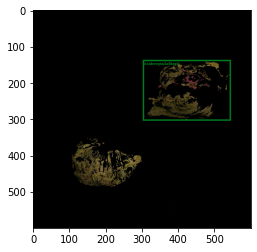

In [65]:
# Lets view a sample
sample = train_dataset[0]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [66]:
len(train_dataset)

87

## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [86]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [87]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [88]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training

In [89]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [90]:
device = torch.device("cuda") # use GPU to train

In [91]:
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [92]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [93]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [94]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [95]:
num_epochs=100

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 22/22 [00:34<00:00,  1.57s/it]


Epoch 0, lr: 0.010000, loss: 0.780506, loss_classifier: 0.157076, loss_box: 0.011896, loss_rpn_box: 0.017063, loss_object: 0.594471


100%|██████████| 22/22 [00:34<00:00,  1.58s/it]


Epoch 1, lr: 0.010000, loss: 0.371528, loss_classifier: 0.101991, loss_box: 0.071767, loss_rpn_box: 0.016003, loss_object: 0.181767


100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 2, lr: 0.010000, loss: 0.435500, loss_classifier: 0.166281, loss_box: 0.163781, loss_rpn_box: 0.016600, loss_object: 0.088838


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 3, lr: 0.010000, loss: 0.401765, loss_classifier: 0.154757, loss_box: 0.156906, loss_rpn_box: 0.015904, loss_object: 0.074198


100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 4, lr: 0.010000, loss: 0.387143, loss_classifier: 0.150475, loss_box: 0.149436, loss_rpn_box: 0.015599, loss_object: 0.071633


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 5, lr: 0.010000, loss: 0.353015, loss_classifier: 0.137501, loss_box: 0.132442, loss_rpn_box: 0.015079, loss_object: 0.067993


100%|██████████| 22/22 [00:32<00:00,  1.49s/it]


Epoch 6, lr: 0.010000, loss: 0.297620, loss_classifier: 0.111491, loss_box: 0.107367, loss_rpn_box: 0.015034, loss_object: 0.063728


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 7, lr: 0.010000, loss: 0.282693, loss_classifier: 0.109301, loss_box: 0.101371, loss_rpn_box: 0.015056, loss_object: 0.056965


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 8, lr: 0.010000, loss: 0.324720, loss_classifier: 0.131269, loss_box: 0.130481, loss_rpn_box: 0.014920, loss_object: 0.048050


100%|██████████| 22/22 [00:33<00:00,  1.52s/it]


Epoch 9, lr: 0.010000, loss: 0.362819, loss_classifier: 0.145349, loss_box: 0.159866, loss_rpn_box: 0.015000, loss_object: 0.042604


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 10, lr: 0.010000, loss: 0.349574, loss_classifier: 0.140837, loss_box: 0.153557, loss_rpn_box: 0.014931, loss_object: 0.040250


100%|██████████| 22/22 [00:32<00:00,  1.49s/it]


Epoch 11, lr: 0.010000, loss: 0.343939, loss_classifier: 0.136178, loss_box: 0.147741, loss_rpn_box: 0.015280, loss_object: 0.044740


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 12, lr: 0.010000, loss: 0.321693, loss_classifier: 0.132858, loss_box: 0.133214, loss_rpn_box: 0.014362, loss_object: 0.041259


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 13, lr: 0.010000, loss: 0.342170, loss_classifier: 0.135745, loss_box: 0.152426, loss_rpn_box: 0.014243, loss_object: 0.039756


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 14, lr: 0.010000, loss: 0.349831, loss_classifier: 0.137161, loss_box: 0.159590, loss_rpn_box: 0.013667, loss_object: 0.039412


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 15, lr: 0.010000, loss: 0.366986, loss_classifier: 0.149221, loss_box: 0.167138, loss_rpn_box: 0.014107, loss_object: 0.036519


100%|██████████| 22/22 [00:32<00:00,  1.49s/it]


Epoch 16, lr: 0.010000, loss: 0.316672, loss_classifier: 0.124348, loss_box: 0.142248, loss_rpn_box: 0.013758, loss_object: 0.036318


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 17, lr: 0.010000, loss: 0.351719, loss_classifier: 0.136125, loss_box: 0.164636, loss_rpn_box: 0.013324, loss_object: 0.037634


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 18, lr: 0.010000, loss: 0.329425, loss_classifier: 0.129606, loss_box: 0.149642, loss_rpn_box: 0.013732, loss_object: 0.036445


100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 19, lr: 0.010000, loss: 0.336868, loss_classifier: 0.131711, loss_box: 0.155504, loss_rpn_box: 0.013479, loss_object: 0.036175


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 20, lr: 0.010000, loss: 0.326518, loss_classifier: 0.132600, loss_box: 0.145773, loss_rpn_box: 0.013655, loss_object: 0.034490


100%|██████████| 22/22 [00:32<00:00,  1.50s/it]


Epoch 21, lr: 0.010000, loss: 0.296357, loss_classifier: 0.119633, loss_box: 0.131929, loss_rpn_box: 0.012968, loss_object: 0.031826


100%|██████████| 22/22 [00:33<00:00,  1.50s/it]


Epoch 22, lr: 0.010000, loss: 0.317307, loss_classifier: 0.122654, loss_box: 0.151211, loss_rpn_box: 0.012702, loss_object: 0.030740


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 23, lr: 0.010000, loss: 0.280221, loss_classifier: 0.107444, loss_box: 0.128395, loss_rpn_box: 0.013163, loss_object: 0.031220


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 24, lr: 0.010000, loss: 0.318623, loss_classifier: 0.126384, loss_box: 0.145839, loss_rpn_box: 0.012857, loss_object: 0.033543


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 25, lr: 0.010000, loss: 0.287376, loss_classifier: 0.110047, loss_box: 0.134844, loss_rpn_box: 0.012886, loss_object: 0.029599


100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 26, lr: 0.010000, loss: 0.277364, loss_classifier: 0.103108, loss_box: 0.132576, loss_rpn_box: 0.012279, loss_object: 0.029402


100%|██████████| 22/22 [00:32<00:00,  1.50s/it]


Epoch 27, lr: 0.010000, loss: 0.295161, loss_classifier: 0.113492, loss_box: 0.142476, loss_rpn_box: 0.012039, loss_object: 0.027154


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 28, lr: 0.010000, loss: 0.313441, loss_classifier: 0.120866, loss_box: 0.154597, loss_rpn_box: 0.012798, loss_object: 0.025180


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 29, lr: 0.010000, loss: 0.287400, loss_classifier: 0.112952, loss_box: 0.136759, loss_rpn_box: 0.012105, loss_object: 0.025584


100%|██████████| 22/22 [00:32<00:00,  1.49s/it]


Epoch 30, lr: 0.010000, loss: 0.271807, loss_classifier: 0.104227, loss_box: 0.128981, loss_rpn_box: 0.012100, loss_object: 0.026500


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 31, lr: 0.010000, loss: 0.291681, loss_classifier: 0.111708, loss_box: 0.141492, loss_rpn_box: 0.012352, loss_object: 0.026128


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 32, lr: 0.010000, loss: 0.282295, loss_classifier: 0.105875, loss_box: 0.139915, loss_rpn_box: 0.011395, loss_object: 0.025110


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 33, lr: 0.010000, loss: 0.296476, loss_classifier: 0.112583, loss_box: 0.148018, loss_rpn_box: 0.011819, loss_object: 0.024055


100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 34, lr: 0.010000, loss: 0.260217, loss_classifier: 0.099404, loss_box: 0.130562, loss_rpn_box: 0.011183, loss_object: 0.019068


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 35, lr: 0.010000, loss: 0.259325, loss_classifier: 0.097651, loss_box: 0.126752, loss_rpn_box: 0.011299, loss_object: 0.023623


100%|██████████| 22/22 [00:32<00:00,  1.49s/it]


Epoch 36, lr: 0.010000, loss: 0.243875, loss_classifier: 0.088055, loss_box: 0.123631, loss_rpn_box: 0.010886, loss_object: 0.021303


100%|██████████| 22/22 [00:32<00:00,  1.49s/it]


Epoch 37, lr: 0.010000, loss: 0.253274, loss_classifier: 0.095759, loss_box: 0.125878, loss_rpn_box: 0.011346, loss_object: 0.020291


100%|██████████| 22/22 [00:33<00:00,  1.50s/it]


Epoch 38, lr: 0.010000, loss: 0.255009, loss_classifier: 0.096202, loss_box: 0.125852, loss_rpn_box: 0.010924, loss_object: 0.022030


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 39, lr: 0.010000, loss: 0.240644, loss_classifier: 0.090502, loss_box: 0.119648, loss_rpn_box: 0.010843, loss_object: 0.019651


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 40, lr: 0.010000, loss: 0.253484, loss_classifier: 0.096419, loss_box: 0.126491, loss_rpn_box: 0.011346, loss_object: 0.019228


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 41, lr: 0.010000, loss: 0.214485, loss_classifier: 0.077157, loss_box: 0.108791, loss_rpn_box: 0.010586, loss_object: 0.017950


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 42, lr: 0.010000, loss: 0.228054, loss_classifier: 0.080903, loss_box: 0.117245, loss_rpn_box: 0.010325, loss_object: 0.019581


100%|██████████| 22/22 [00:33<00:00,  1.51s/it]


Epoch 43, lr: 0.010000, loss: 0.211164, loss_classifier: 0.072931, loss_box: 0.107919, loss_rpn_box: 0.010925, loss_object: 0.019388


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 44, lr: 0.010000, loss: 0.201462, loss_classifier: 0.072224, loss_box: 0.100909, loss_rpn_box: 0.010601, loss_object: 0.017728


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 45, lr: 0.010000, loss: 0.189409, loss_classifier: 0.070385, loss_box: 0.093998, loss_rpn_box: 0.010564, loss_object: 0.014461


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 46, lr: 0.010000, loss: 0.211626, loss_classifier: 0.080844, loss_box: 0.105658, loss_rpn_box: 0.010125, loss_object: 0.014999


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 47, lr: 0.010000, loss: 0.208056, loss_classifier: 0.071250, loss_box: 0.110311, loss_rpn_box: 0.010542, loss_object: 0.015952


100%|██████████| 22/22 [00:33<00:00,  1.50s/it]


Epoch 48, lr: 0.010000, loss: 0.184812, loss_classifier: 0.063465, loss_box: 0.094555, loss_rpn_box: 0.010591, loss_object: 0.016201


100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 49, lr: 0.010000, loss: 0.188686, loss_classifier: 0.063483, loss_box: 0.100608, loss_rpn_box: 0.009857, loss_object: 0.014738


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 50, lr: 0.010000, loss: 0.182651, loss_classifier: 0.062033, loss_box: 0.098302, loss_rpn_box: 0.009272, loss_object: 0.013044


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 51, lr: 0.010000, loss: 0.179530, loss_classifier: 0.062515, loss_box: 0.093294, loss_rpn_box: 0.009140, loss_object: 0.014581


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 52, lr: 0.010000, loss: 0.193255, loss_classifier: 0.070539, loss_box: 0.096068, loss_rpn_box: 0.008995, loss_object: 0.017654


100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 53, lr: 0.010000, loss: 0.184783, loss_classifier: 0.069598, loss_box: 0.092159, loss_rpn_box: 0.009913, loss_object: 0.013112


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 54, lr: 0.010000, loss: 0.193290, loss_classifier: 0.068959, loss_box: 0.100463, loss_rpn_box: 0.009950, loss_object: 0.013917


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 55, lr: 0.010000, loss: 0.195414, loss_classifier: 0.067220, loss_box: 0.102831, loss_rpn_box: 0.009650, loss_object: 0.015713


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 56, lr: 0.010000, loss: 0.177468, loss_classifier: 0.062332, loss_box: 0.091927, loss_rpn_box: 0.009959, loss_object: 0.013250


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 57, lr: 0.010000, loss: 0.176306, loss_classifier: 0.060896, loss_box: 0.094196, loss_rpn_box: 0.009002, loss_object: 0.012211


100%|██████████| 22/22 [00:34<00:00,  1.56s/it]


Epoch 58, lr: 0.010000, loss: 0.169796, loss_classifier: 0.056294, loss_box: 0.091675, loss_rpn_box: 0.008889, loss_object: 0.012938


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 59, lr: 0.010000, loss: 0.151923, loss_classifier: 0.052618, loss_box: 0.080417, loss_rpn_box: 0.008672, loss_object: 0.010216


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 60, lr: 0.010000, loss: 0.136332, loss_classifier: 0.042988, loss_box: 0.074242, loss_rpn_box: 0.008142, loss_object: 0.010960


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 61, lr: 0.010000, loss: 0.161941, loss_classifier: 0.055182, loss_box: 0.084874, loss_rpn_box: 0.008233, loss_object: 0.013653


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 62, lr: 0.010000, loss: 0.145406, loss_classifier: 0.047941, loss_box: 0.077584, loss_rpn_box: 0.009299, loss_object: 0.010581


100%|██████████| 22/22 [00:32<00:00,  1.49s/it]


Epoch 63, lr: 0.010000, loss: 0.154383, loss_classifier: 0.052623, loss_box: 0.082361, loss_rpn_box: 0.008722, loss_object: 0.010677


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 64, lr: 0.010000, loss: 0.135937, loss_classifier: 0.045011, loss_box: 0.073421, loss_rpn_box: 0.007784, loss_object: 0.009721


100%|██████████| 22/22 [00:32<00:00,  1.49s/it]


Epoch 65, lr: 0.010000, loss: 0.138308, loss_classifier: 0.045907, loss_box: 0.075223, loss_rpn_box: 0.008156, loss_object: 0.009021


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 66, lr: 0.010000, loss: 0.148310, loss_classifier: 0.049532, loss_box: 0.079379, loss_rpn_box: 0.007972, loss_object: 0.011427


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 67, lr: 0.010000, loss: 0.142434, loss_classifier: 0.047893, loss_box: 0.078399, loss_rpn_box: 0.007601, loss_object: 0.008541


100%|██████████| 22/22 [00:32<00:00,  1.50s/it]


Epoch 68, lr: 0.010000, loss: 0.131264, loss_classifier: 0.040914, loss_box: 0.072151, loss_rpn_box: 0.007796, loss_object: 0.010404


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 69, lr: 0.010000, loss: 0.139925, loss_classifier: 0.047735, loss_box: 0.075888, loss_rpn_box: 0.007558, loss_object: 0.008743


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 70, lr: 0.010000, loss: 0.125600, loss_classifier: 0.040120, loss_box: 0.070780, loss_rpn_box: 0.007010, loss_object: 0.007690


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 71, lr: 0.010000, loss: 0.137112, loss_classifier: 0.043908, loss_box: 0.076172, loss_rpn_box: 0.007983, loss_object: 0.009050


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 72, lr: 0.010000, loss: 0.120171, loss_classifier: 0.039529, loss_box: 0.064241, loss_rpn_box: 0.007366, loss_object: 0.009035


100%|██████████| 22/22 [00:33<00:00,  1.50s/it]


Epoch 73, lr: 0.010000, loss: 0.129648, loss_classifier: 0.041398, loss_box: 0.071285, loss_rpn_box: 0.007470, loss_object: 0.009494


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 74, lr: 0.010000, loss: 0.122732, loss_classifier: 0.040205, loss_box: 0.063976, loss_rpn_box: 0.007372, loss_object: 0.011179


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 75, lr: 0.010000, loss: 0.124654, loss_classifier: 0.041890, loss_box: 0.064728, loss_rpn_box: 0.007367, loss_object: 0.010668


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 76, lr: 0.010000, loss: 0.108473, loss_classifier: 0.032733, loss_box: 0.059666, loss_rpn_box: 0.007641, loss_object: 0.008432


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 77, lr: 0.010000, loss: 0.102106, loss_classifier: 0.032243, loss_box: 0.056023, loss_rpn_box: 0.007272, loss_object: 0.006569


100%|██████████| 22/22 [00:33<00:00,  1.51s/it]


Epoch 78, lr: 0.010000, loss: 0.100509, loss_classifier: 0.031310, loss_box: 0.055396, loss_rpn_box: 0.006929, loss_object: 0.006874


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 79, lr: 0.010000, loss: 0.115994, loss_classifier: 0.034371, loss_box: 0.064939, loss_rpn_box: 0.007977, loss_object: 0.008706


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 80, lr: 0.010000, loss: 0.104355, loss_classifier: 0.031544, loss_box: 0.059516, loss_rpn_box: 0.006600, loss_object: 0.006695


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 81, lr: 0.010000, loss: 0.102867, loss_classifier: 0.031025, loss_box: 0.059008, loss_rpn_box: 0.006726, loss_object: 0.006108


100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 82, lr: 0.010000, loss: 0.105785, loss_classifier: 0.031430, loss_box: 0.058222, loss_rpn_box: 0.007163, loss_object: 0.008969


100%|██████████| 22/22 [00:33<00:00,  1.50s/it]


Epoch 83, lr: 0.010000, loss: 0.112807, loss_classifier: 0.035176, loss_box: 0.063651, loss_rpn_box: 0.007072, loss_object: 0.006907


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 84, lr: 0.010000, loss: 0.098252, loss_classifier: 0.030872, loss_box: 0.055591, loss_rpn_box: 0.006409, loss_object: 0.005380


100%|██████████| 22/22 [00:32<00:00,  1.49s/it]


Epoch 85, lr: 0.010000, loss: 0.105309, loss_classifier: 0.033660, loss_box: 0.059901, loss_rpn_box: 0.006606, loss_object: 0.005142


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 86, lr: 0.010000, loss: 0.095135, loss_classifier: 0.029187, loss_box: 0.053351, loss_rpn_box: 0.006490, loss_object: 0.006107


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 87, lr: 0.010000, loss: 0.098092, loss_classifier: 0.030175, loss_box: 0.053589, loss_rpn_box: 0.006313, loss_object: 0.008015


100%|██████████| 22/22 [00:34<00:00,  1.58s/it]


Epoch 88, lr: 0.010000, loss: 0.097518, loss_classifier: 0.031899, loss_box: 0.051938, loss_rpn_box: 0.006231, loss_object: 0.007451


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 89, lr: 0.010000, loss: 0.099226, loss_classifier: 0.032726, loss_box: 0.052826, loss_rpn_box: 0.006497, loss_object: 0.007178


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 90, lr: 0.010000, loss: 0.093054, loss_classifier: 0.029480, loss_box: 0.051011, loss_rpn_box: 0.006212, loss_object: 0.006352


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 91, lr: 0.010000, loss: 0.095494, loss_classifier: 0.028780, loss_box: 0.054496, loss_rpn_box: 0.006539, loss_object: 0.005679


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 92, lr: 0.010000, loss: 0.102686, loss_classifier: 0.033905, loss_box: 0.054820, loss_rpn_box: 0.006441, loss_object: 0.007519


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 93, lr: 0.010000, loss: 0.091833, loss_classifier: 0.027901, loss_box: 0.051665, loss_rpn_box: 0.005917, loss_object: 0.006350


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 94, lr: 0.010000, loss: 0.088552, loss_classifier: 0.026233, loss_box: 0.051665, loss_rpn_box: 0.005892, loss_object: 0.004762


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 95, lr: 0.010000, loss: 0.088701, loss_classifier: 0.026039, loss_box: 0.050474, loss_rpn_box: 0.005792, loss_object: 0.006396


100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Epoch 96, lr: 0.010000, loss: 0.090505, loss_classifier: 0.028440, loss_box: 0.050745, loss_rpn_box: 0.006142, loss_object: 0.005178


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 97, lr: 0.010000, loss: 0.090468, loss_classifier: 0.028012, loss_box: 0.050599, loss_rpn_box: 0.006160, loss_object: 0.005696


100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 98, lr: 0.010000, loss: 0.084908, loss_classifier: 0.025566, loss_box: 0.047688, loss_rpn_box: 0.006012, loss_object: 0.005642


100%|██████████| 22/22 [00:32<00:00,  1.48s/it]

Epoch 99, lr: 0.010000, loss: 0.082327, loss_classifier: 0.023888, loss_box: 0.048699, loss_rpn_box: 0.005701, loss_object: 0.004038


In [96]:
%tb

No traceback available to show.


In [97]:
# our learning rate was too low, due to a lr scheduler bug. For this task, we wont need a scheudul.er

## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [98]:
torch.save(model, "/content/drive/MyDrive/faster_r-cnn/saved_models/resnet50_green_100_epochs.pth")

In [99]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [100]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [101]:
img, _ = test_dataset[2]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [54]:
# it did learn

In [102]:
prediction

[{'boxes': tensor([[ 42.2231, 240.1285, 273.7455, 382.9669],
          [229.2401, 186.3697, 404.9801, 296.9743],
          [253.6965, 276.1761, 405.9185, 379.4269],
          [342.8807, 241.0555, 401.5960, 288.7566],
          [185.4093, 251.0476, 410.0235, 409.4712],
          [189.3013, 206.2750, 417.0029, 354.4676],
          [223.0470, 191.7033, 403.6611, 282.9039],
          [ 14.3666, 464.0072, 210.9199, 583.1743],
          [ 29.7310, 243.3209, 275.0747, 367.4411],
          [156.2655, 342.4803, 234.9733, 407.8588]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 2, 1, 2, 2], device='cuda:0'),
  'scores': tensor([0.9894, 0.9614, 0.9494, 0.5282, 0.2341, 0.1209, 0.1176, 0.0694, 0.0592,
          0.0505], device='cuda:0')}]

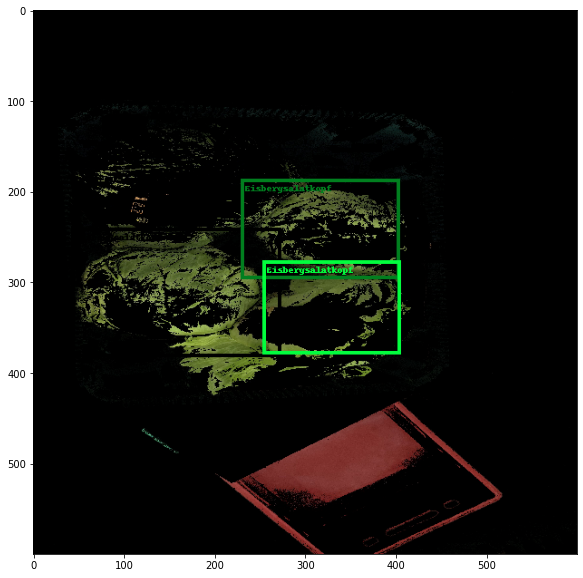

In [105]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))